## Lesson-06 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
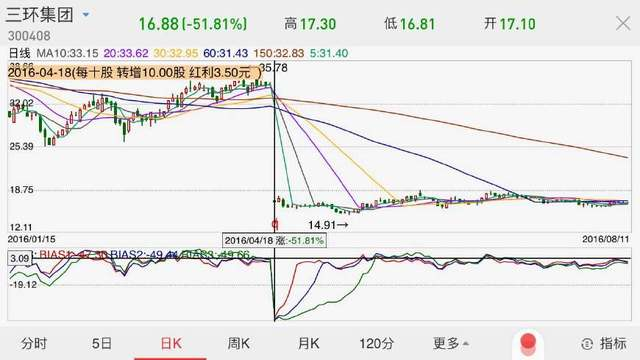

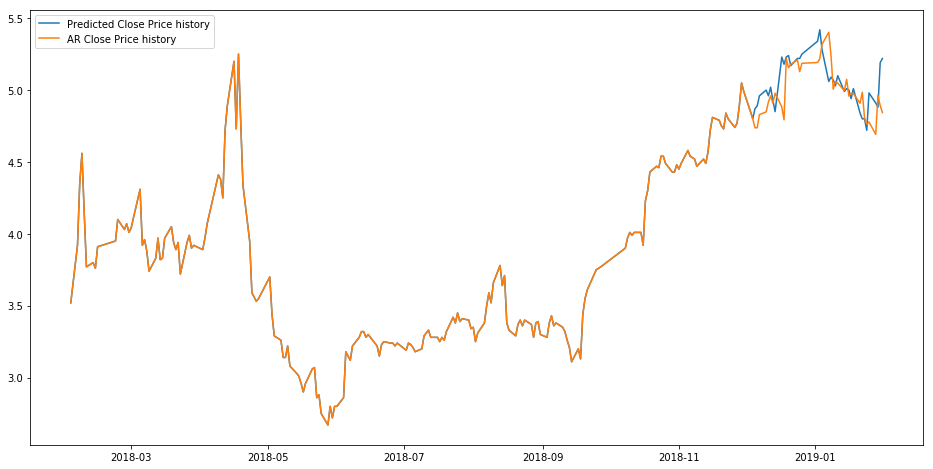

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [14]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [15]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [16]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [17]:
n_categories

18

In [18]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [19]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [20]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

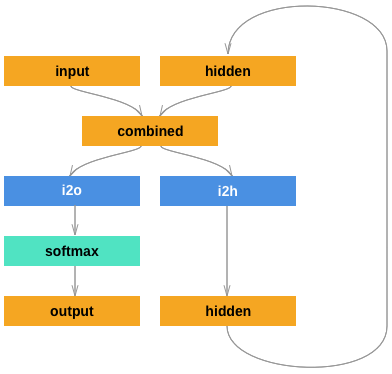

In [21]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [22]:
rnn = RNN(n_letters, n_hidden, n_categories)

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [23]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [24]:
output

tensor([[-2.9050, -2.8176, -2.9059, -3.0373, -2.9428, -2.8723, -2.9691, -2.9059,
         -2.8975, -2.8942, -2.8153, -2.8659, -2.9185, -2.8701, -2.9025, -2.7989,
         -2.8499, -2.8850]], grad_fn=<LogSoftmaxBackward>)

In [25]:
next_hidden

tensor([[ 0.0070, -0.1090, -0.0030, -0.0139,  0.0130, -0.1413,  0.0804, -0.0830,
         -0.0198,  0.0236,  0.1206,  0.0287, -0.0084,  0.0038,  0.0437,  0.0429,
          0.0206, -0.1122,  0.0102,  0.0181,  0.0056,  0.0345, -0.0365, -0.1010,
         -0.0929,  0.0077,  0.0179,  0.0161,  0.1157, -0.0624, -0.0299,  0.0073,
         -0.0081,  0.0377,  0.0598, -0.0326,  0.0263, -0.0143, -0.1025, -0.0793,
         -0.1079,  0.0970,  0.0441,  0.0870,  0.0630,  0.0044,  0.0081,  0.0100,
         -0.1339,  0.0491,  0.0085,  0.1009,  0.0232, -0.0667, -0.0207,  0.0982,
         -0.0656,  0.0584,  0.0639,  0.1140,  0.0438, -0.0624, -0.0287, -0.1236,
         -0.0162,  0.0085, -0.1051,  0.1369,  0.0136, -0.0291, -0.0051, -0.0911,
          0.0499,  0.1188,  0.0438, -0.0069,  0.1004,  0.1009,  0.0113,  0.0842,
         -0.0002,  0.1218,  0.0468, -0.0841,  0.0003, -0.0005, -0.0231,  0.0394,
          0.0288,  0.0040, -0.0274,  0.0539,  0.0992, -0.0132,  0.0286, -0.0265,
         -0.0777,  0.1337, -

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [26]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(next_hidden)

tensor([[-2.9050, -2.8176, -2.9059, -3.0373, -2.9428, -2.8723, -2.9691, -2.9059,
         -2.8975, -2.8942, -2.8153, -2.8659, -2.9185, -2.8701, -2.9025, -2.7989,
         -2.8499, -2.8850]], grad_fn=<LogSoftmaxBackward>)
tensor([[ 0.0070, -0.1090, -0.0030, -0.0139,  0.0130, -0.1413,  0.0804, -0.0830,
         -0.0198,  0.0236,  0.1206,  0.0287, -0.0084,  0.0038,  0.0437,  0.0429,
          0.0206, -0.1122,  0.0102,  0.0181,  0.0056,  0.0345, -0.0365, -0.1010,
         -0.0929,  0.0077,  0.0179,  0.0161,  0.1157, -0.0624, -0.0299,  0.0073,
         -0.0081,  0.0377,  0.0598, -0.0326,  0.0263, -0.0143, -0.1025, -0.0793,
         -0.1079,  0.0970,  0.0441,  0.0870,  0.0630,  0.0044,  0.0081,  0.0100,
         -0.1339,  0.0491,  0.0085,  0.1009,  0.0232, -0.0667, -0.0207,  0.0982,
         -0.0656,  0.0584,  0.0639,  0.1140,  0.0438, -0.0624, -0.0287, -0.1236,
         -0.0162,  0.0085, -0.1051,  0.1369,  0.0136, -0.0291, -0.0051, -0.0911,
          0.0499,  0.1188,  0.0438, -0.0069,  0.10

这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [27]:
len(all_categories)

18

In [28]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



对于刚刚产生的output，我们使用这个函数

In [29]:
print(category_from_output(output), all_categories)

('Scottish', 15) ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


### 1.8 随机生成训练数据

In [30]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Japanese / line = Ohmae
category = Irish / line = O'Neill
category = Chinese / line = Shao
category = Korean / line = Ra
category = Chinese / line = Que
category = Korean / line = Ko
category = Dutch / line = Middelburg
category = Korean / line = Ngai
category = Korean / line = Moon
category = Arabic / line = Boutros


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [31]:
criterion = nn.CrossEntropyLoss()

In [32]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [33]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 1s) 2.9053 Klerken / Russian ✗ (Dutch)
1000 10% (0m 2s) 2.8853 Michel / Russian ✗ (Polish)
1500 15% (0m 4s) 2.8192 Ochoa / Greek ✗ (Spanish)
2000 20% (0m 6s) 2.8701 Hayata / Arabic ✗ (Japanese)
2500 25% (0m 8s) 2.7847 Perrot / German ✗ (French)
3000 30% (0m 10s) 2.4540 Yamschikov / Russian ✓
3500 35% (0m 12s) 3.0270 Ishikawa / Italian ✗ (Japanese)
4000 40% (0m 14s) 2.8680 Isa / Vietnamese ✗ (Arabic)
4500 45% (0m 16s) 1.4669 Panoulias / Greek ✓
5000 50% (0m 17s) 2.4668 Akkeren / Irish ✗ (Dutch)
5500 55% (0m 19s) 2.6231 Prchal / Arabic ✗ (Czech)
6000 60% (0m 21s) 1.5458 Sook / Korean ✓
6500 65% (0m 22s) 2.8072 Eoin / Chinese ✗ (Irish)
7000 70% (0m 24s) 2.5341 Trueman / Scottish ✗ (English)
7500 75% (0m 26s) 2.6606 Forestier / German ✗ (French)
8000 80% (0m 27s) 1.5180 Tieu / Chinese ✗ (Vietnamese)
8500 85% (0m 29s) 2.6604 Houtem / English ✗ (Dutch)
9000 90% (0m 31s) 1.3613 Chin / Chinese ✗ (Korean)
9500 95% (0m 32s) 2.6100 Mikhail / Japanese ✗ (Arabic)
10000 100% (0m 34s) 0.45

### 1.9 观察Loss的变化

In [21]:
all_losses

[2.900480380058289,
 2.8843475651741026,
 2.8827739191055297,
 2.881629853248596,
 2.85435968875885,
 2.876875410079956,
 2.869914710521698,
 2.857447271347046,
 2.8500211238861084,
 2.847122254371643,
 2.8484931492805483,
 2.8459708857536317,
 2.843790125846863,
 2.8317862939834595,
 2.8407901906967163,
 2.8100576758384705,
 2.8291651678085326,
 2.8279801416397095,
 2.8094021344184874,
 2.81765202999115,
 2.8064199781417845,
 2.8092317676544187,
 2.8098020792007445,
 2.7876397490501406,
 2.772988438606262,
 2.7758224844932555,
 2.767463381290436,
 2.7434300136566163,
 2.758952715396881,
 2.786548686027527,
 2.763988516330719,
 2.7584344005584716,
 2.7306005334854127,
 2.7214073753356933,
 2.758383548259735,
 2.7076880526542664,
 2.689888941049576,
 2.6709635877609252,
 2.7167211735248564,
 2.7035507380962374,
 2.694727215766907,
 2.662196983098984,
 2.6139786005020142,
 2.6549633133411406,
 2.6658816170692443,
 2.6469427502155303,
 2.652452049255371,
 2.6149337494373324,
 2.5303569781

In [22]:
%matplotlib inline

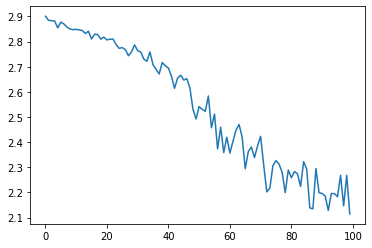

In [23]:
plt.plot(all_losses)

In [24]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('John')
predict('Tom')
predict('Satoshi')


> John
(-1.41) Korean
(-1.83) Vietnamese
(-1.84) Chinese

> Tom
(-0.91) Korean
(-1.64) Chinese
(-1.72) Vietnamese

> Satoshi
(-1.72) Polish
(-1.84) Italian
(-2.54) Japanese


## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

> todo

In [105]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 1024

In [106]:
rnn = RNN(n_letters, n_hidden, n_categories)

In [107]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
criterion = nn.CrossEntropyLoss()

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
#     print(output.shape, category_tensor.shape)
#     print(output, category_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [108]:
import time
import math

n_iters = 2000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 25% (0m 38s) 3.0233     O'Connor / Czech ✗ (Irish)
1000 50% (1m 15s) 2.7178       Torres / Portuguese ✓
1500 75% (1m 49s) 2.8419        Thach / Czech ✗ (Vietnamese)
2000 100% (2m 24s) 2.8576       Garcia / Portuguese ✗ (Spanish)


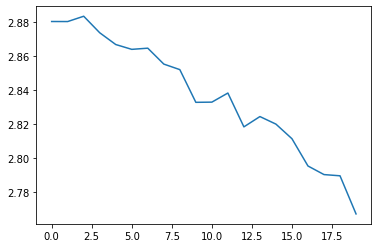

In [109]:
plt.plot(all_losses)

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

> todo

In [25]:
values = []
[values.extend(el) for el in category_lines.values()]
len(values)

20074

In [26]:
values = [len(el) for el in values]

In [27]:
from collections import Counter
counter = Counter(values)

<BarContainer object of 18 artists>

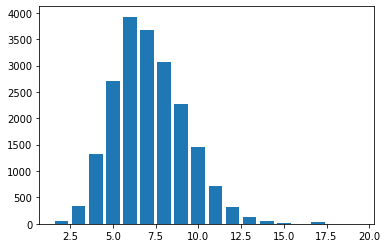

In [28]:
plt.bar(counter.keys(), counter.values())

In [29]:
max_length = 12

In [30]:
for k, v in category_lines.items():
    v = [(el.rjust(max_length, ' ') if len(el) < max_length else el[:max_length]) for el in v]
    category_lines[k] = v

In [49]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

In [50]:
n_letters

57

In [75]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers=1):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.layers = layers
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size)
        self.fc = nn.Linear(n_hidden,output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input.reshape(1,1,self.input_size), hidden)
        output = self.fc(output[:, -1, :])
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(self.layers, 1, self.hidden_size), torch.zeros(self.layers, 1, self.hidden_size))

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)


def train(category_tensor, input):
    lstm.zero_grad()
    
    hidden = lstm.initHidden()
    for i in range(input.size()[0]):
        output, hidden = lstm(input[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    optimizer.step()
    
    return output, loss.item()


1000 10% (0m 8s) 2.8882 Onopko / Portuguese ✗ (Russian)
2000 20% (0m 20s) 2.8885 Tangeman / Portuguese ✗ (German)
3000 30% (0m 30s) 2.8887 Balahowski / Portuguese ✗ (Russian)
4000 40% (0m 40s) 2.8896 Fakhoury / Portuguese ✗ (Arabic)
5000 50% (0m 49s) 2.8938 Kuang / Portuguese ✗ (Chinese)
6000 60% (1m 0s) 2.8852 Moreno / Portuguese ✓
7000 70% (1m 10s) 2.8900 Haddad / Portuguese ✗ (Arabic)
8000 80% (1m 20s) 2.8885 Neuman / Portuguese ✗ (German)
9000 90% (1m 29s) 2.8959 Soucy / Portuguese ✗ (French)
10000 100% (1m 39s) 2.8878 Klerks / Portuguese ✗ (Dutch)


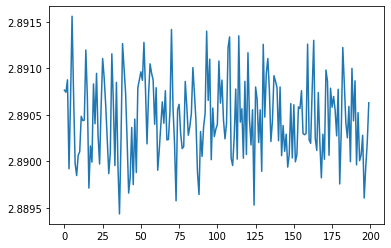

In [77]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 50


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = category_from_output(output[-1])
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
        
plt.plot(all_losses)

In [69]:
plot_every = 20


In [70]:
def train_on_model(category_tensor, line_tensor, model, optimizer):
    hidden = model.initHidden()

    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    
    optimizer.step()
    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in model.parameters():
    #   p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [71]:
def test(test_model, train_model, n_iters=10000, learning_rate=1e-4, printout=True, drawout=True):
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    optimizer = torch.optim.Adam(test_model.parameters(), lr=learning_rate)

    start = time.time()
    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = sample_trainning()
        output, loss = train_model(category_tensor, line_tensor, test_model, optimizer)
        current_loss += loss
        # Print iter number, loss, name and guess
        if printout and iter % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    if drawout:
        plt.plot(all_losses)

In [72]:
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size)
        self.fc = nn.Linear(n_hidden,output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input.reshape(1,1,self.input_size), hidden)
        output = self.fc(output[:, -1, :])
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(self.n_layers, 1, self.hidden_size), torch.zeros(self.n_layers, 1, self.hidden_size))

In [73]:
lstm = LSTM(n_letters, n_hidden, n_categories, 1)


100 5% (0m 0s) 2.8916 Totah / English ✗ (Arabic)
200 10% (0m 1s) 2.9006 She / English ✗ (Chinese)
300 15% (0m 2s) 2.7951 Pantelas / Greek ✓
400 20% (0m 3s) 2.9052 Brambilla / Greek ✗ (Italian)
500 25% (0m 5s) 2.8678 Ha / Vietnamese ✓
600 30% (0m 6s) 2.9177 Serafim / Japanese ✗ (Portuguese)
700 35% (0m 7s) 2.9063 Vaca / Korean ✗ (Czech)
800 40% (0m 8s) 2.9235 Karamorita / English ✗ (Japanese)
900 45% (0m 9s) 2.8208 Kuiper / English ✗ (Dutch)
1000 50% (0m 10s) 2.9626 Vozab / English ✗ (Czech)
1100 55% (0m 12s) 2.9548 Berg / English ✗ (German)
1200 60% (0m 13s) 2.9476 Gonzalez / Greek ✗ (Spanish)
1300 65% (0m 15s) 2.9775 Wood / Chinese ✗ (Scottish)
1400 70% (0m 17s) 2.9063 Kennedy / English ✗ (Scottish)
1500 75% (0m 18s) 2.9286 Sauvageot / Russian ✗ (French)
1600 80% (0m 19s) 2.9134 Archambault / Greek ✗ (French)
1700 85% (0m 21s) 2.8920 Venne / English ✗ (Dutch)
1800 90% (0m 22s) 2.9544 Castellano / Russian ✗ (Spanish)
1900 95% (0m 24s) 2.9433 Romijnsen / Russian ✗ (Dutch)
2000 100% (0m 

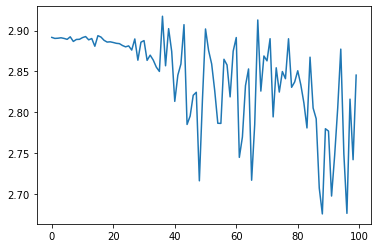

In [74]:
test(lstm, train_on_model, n_iters=2000, learning_rate=0.001)


In [473]:
n_hidden = 128
# rnn = nn.LSTM(max_length, n_hidden, 1)
rnn = nn.GRU(n_letters, n_hidden)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    l = nn.Linear(128,18)
    softmax = nn.LogSoftmax(dim=1)
    
    rnn.zero_grad()
    l.zero_grad()
    softmax.zero_grad()
    
    hn = torch.randn(1, 1, n_hidden)
    output, hn = rnn(line_tensor, hn)
    
    output = output[0][-1:][:]
    output = softmax(l(output))
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    
    for p in softmax.parameters():
        p.data.add(-learning_rate, p.grad.data)
        
    for p in l.parameters():
        p.data.add(-learning_rate, p.grad.data)
        
    for p in rnn.parameters():
        p.data.add(-learning_rate, p.grad.data)
    
    return output, loss.item()


In [474]:
import time
import math

n_iters = 3000 # 这个数字你可以调大一些
print_every = 100
plot_every = 10


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
#     print(category, line, (category_tensor,line_tensor.shape))
#     raise
#     print(category_tensor.shape, line_tensor.shape)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = category_from_output(output[-1])
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

100 3% (0m 0s) 3.3487    Sauvageon / Russian ✗ (French)
200 6% (0m 1s) 2.7625         Harb / German ✗ (Arabic)
300 10% (0m 2s) 2.8974     Adamczyk / Korean ✗ (Polish)
400 13% (0m 3s) 2.2728       Ransom / Czech ✓
500 16% (0m 4s) 3.0250     Roncalli / Czech ✗ (Italian)
600 20% (0m 5s) 3.1158      Schoorl / Polish ✗ (Dutch)
700 23% (0m 6s) 3.1088     Kasprzak / Portuguese ✗ (Polish)
800 26% (0m 7s) 3.3662 Panayiotopou / Italian ✗ (Greek)
900 30% (0m 8s) 3.2824     Paterson / Irish ✗ (Scottish)
1000 33% (0m 9s) 2.6604      Vicario / Portuguese ✗ (Spanish)
1100 36% (0m 10s) 3.1054       Murphy / Vietnamese ✗ (Scottish)
1200 40% (0m 11s) 3.0917          Chi / Polish ✗ (Chinese)
1300 43% (0m 12s) 2.3359      Rozinek / Czech ✓
1400 46% (0m 13s) 3.3814      Olbrich / Spanish ✗ (Czech)
1500 50% (0m 14s) 3.0000        Jirku / Spanish ✗ (Czech)
1600 53% (0m 15s) 2.8133       Nazari / French ✗ (Arabic)
1700 56% (0m 17s) 2.9744    Neaverson / Japanese ✗ (English)
1800 60% (0m 18s) 2.8248        Luo

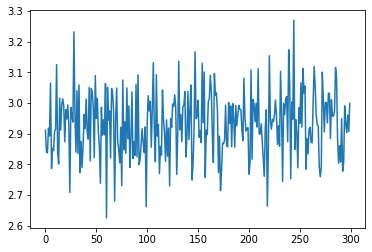

In [475]:
plt.plot(all_losses)

# 老师, 为什么我这个loss不降低啊, 到底是为啥

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

In [476]:
n_hidden = 128
# rnn = nn.LSTM(max_length, n_hidden, 1)
rnn = nn.GRU(n_letters, n_hidden, num_layers=3)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    l = nn.Linear(128,18)
    softmax = nn.LogSoftmax(dim=1)
    
    rnn.zero_grad()
    l.zero_grad()
    softmax.zero_grad()
    
    hn = torch.randn(3, 1, n_hidden)
    output, hn = rnn(line_tensor, hn)
    
    output = output[0][-1:][:]
    output = softmax(l(output))
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    
    for p in softmax.parameters():
        p.data.add(-learning_rate, p.grad.data)
        
    for p in l.parameters():
        p.data.add(-learning_rate, p.grad.data)
        
    for p in rnn.parameters():
        p.data.add(-learning_rate, p.grad.data)
    
    return output, loss.item()


In [477]:
import time
import math

n_iters = 3000 # 这个数字你可以调大一些
print_every = 100
plot_every = 10


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
#     print(category, line, (category_tensor,line_tensor.shape))
#     raise
#     print(category_tensor.shape, line_tensor.shape)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = category_from_output(output[-1])
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

100 3% (0m 2s) 3.1718         Kalb / Scottish ✗ (Arabic)
200 6% (0m 5s) 2.7657     Accursio / Russian ✗ (Italian)
300 10% (0m 7s) 2.9128       Rusnak / Portuguese ✗ (Polish)
400 13% (0m 10s) 2.4652         Doan / Japanese ✗ (Vietnamese)
500 16% (0m 13s) 2.7613       Tracey / Portuguese ✗ (Irish)
600 20% (0m 17s) 2.9816    Pechatkin / English ✗ (Russian)
700 23% (0m 21s) 2.7326       Maruya / Vietnamese ✗ (Japanese)
800 26% (0m 24s) 3.0835          Bui / Scottish ✗ (Vietnamese)
900 30% (0m 27s) 2.8833         Zhai / Polish ✗ (Chinese)
1000 33% (0m 31s) 2.8887      Giersig / Irish ✗ (Czech)
1100 36% (0m 34s) 3.6695      O'Boyle / Spanish ✗ (Irish)
1200 40% (0m 37s) 3.0069        Pudel / English ✗ (Czech)
1300 43% (0m 41s) 2.7413    Bertsimas / Dutch ✗ (Greek)
1400 46% (0m 44s) 2.5333       Kassis / Dutch ✗ (Arabic)
1500 50% (0m 48s) 2.7630    Mizoguchi / Irish ✗ (Japanese)
1600 53% (0m 51s) 3.4175        Chung / Arabic ✗ (Korean)
1700 56% (0m 54s) 3.4169      Iniguez / Polish ✗ (Spanish)

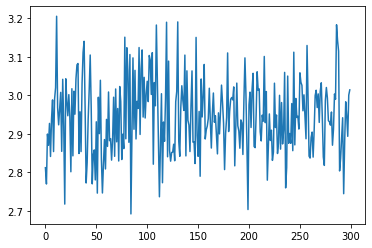

In [478]:
plt.plot(all_losses)

# 老师, 为什么我这个loss不降低啊, 到底是为啥

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

> todo

In [481]:
n_hidden = 128
# rnn = nn.LSTM(max_length, n_hidden, 1)
rnn = nn.GRU(n_letters, n_hidden)

criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    l = nn.Linear(128,18)
    softmax = nn.LogSoftmax(dim=1)
    
    rnn.zero_grad()
    l.zero_grad()
    softmax.zero_grad()
    
    hn = torch.randn(1, 1, n_hidden)
    output, hn = rnn(line_tensor, hn)
    
    output = output[0][-1:][:]
    output = softmax(l(output))
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    
    for p in softmax.parameters():
        p.data.add(-learning_rate, p.grad.data)
        
    for p in l.parameters():
        p.data.add(-learning_rate, p.grad.data)
        
    for p in rnn.parameters():
        p.data.add(-learning_rate, p.grad.data)
    
    return output, loss.item()


In [482]:
import time
import math

n_iters = 3000 # 这个数字你可以调大一些
print_every = 100
plot_every = 10


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
#     print(category, line, (category_tensor,line_tensor.shape))
#     raise
#     print(category_tensor.shape, line_tensor.shape)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = category_from_output(output[-1])
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

100 3% (0m 0s) 3.0401          Dao / English ✗ (Vietnamese)
200 6% (0m 1s) 3.0409        Paris / Korean ✗ (French)
300 10% (0m 2s) 3.1031       Onishi / Arabic ✗ (Japanese)
400 13% (0m 3s) 2.9750       Halfin / Japanese ✗ (Russian)
500 16% (0m 4s) 3.1171      Selmone / Dutch ✗ (Italian)
600 20% (0m 5s) 2.8963       Martin / Portuguese ✗ (French)
700 23% (0m 6s) 2.6629         Peij / Korean ✗ (Dutch)
800 26% (0m 7s) 2.6064      Isaikin / Arabic ✗ (Russian)
900 30% (0m 8s) 2.5731     Kosmatka / Polish ✓
1000 33% (0m 9s) 2.9051       Handal / Vietnamese ✗ (Arabic)
1100 36% (0m 10s) 3.1179        Hyun  / Scottish ✗ (Korean)
1200 40% (0m 12s) 2.5273         Than / French ✗ (Vietnamese)
1300 43% (0m 13s) 3.5005     Ferreira / Irish ✗ (Portuguese)
1400 46% (0m 14s) 2.9352       Parodi / Chinese ✗ (Italian)
1500 50% (0m 15s) 2.7731     Kosmatka / Portuguese ✗ (Polish)
1600 53% (0m 17s) 2.7445     Lukhvich / Dutch ✗ (Russian)
1700 56% (0m 18s) 2.7034       Malouf / Chinese ✗ (Arabic)
1800 60% (

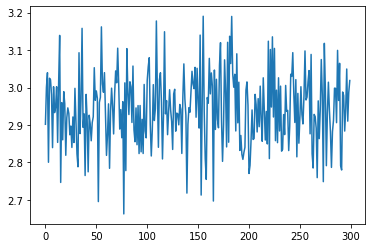

In [483]:
plt.plot(all_losses)

# 老师, 为什么我这个loss不降低啊, 到底是为啥